## SF crime data analysis and modeling

### In this notebook, I would learn how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data). 
The first part is OLAP for scrime data analysis .  
The second part is unsupervised learning for spatial data analysis .   
The option part is the time series data analysis .  
**Note**: I have download the small data (one month e.g. 2018-10) for debug, then download the data from 2013 to 2018 for testing and analysising.

In [3]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [4]:
# read data from the data storage
# Need upload data into databricks community at first. 

crime_data_lines = sc.textFile('/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
print(header)

#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
# display(crimes.take(3))

#get the total number of data 
print(crimes.count())


['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId']
811784

### Solove  big data issues via Spark
approach 1: use RDD (not recommend)  
approach 2: use Dataframe, register the RDD to a dataframe   
approach 3: use SQL

In [6]:

from pyspark.sql import SparkSession
# what's the arguments in config suppose to mean?
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
display(df_opt1)
# what's this suppose to do?
df_opt1.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050


In [7]:

from pyspark.sql import Row

def createRow(keys, values):
  assert len(keys) == len(values)
  mapped = dict(zip(keys, values))
  return Row(**mapped)

# is rdd_rows a RDD? why?
rdd_rows = crimes.map(lambda x: createRow(header, x))
# uncomment code using control+/
# print(rdd_rows.take(1))
df_opt2 = spark.createDataFrame(rdd_rows)
# createOrReplaceTempView would create a new tempory view, what's this suppose to do?
# tempory view is a logical view defined by user manipulation based on true dataset
df_opt2.createOrReplaceTempView("sf_crime")
display(df_opt2)

Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
700 Block of TEHAMA ST,VEHICLE THEFT,05/15/2018,Tuesday,STOLEN MOTORCYCLE,180362289,"(37.77520656149669, -122.41191202732877)",SOUTHERN,18036228907023,NONE,10:30,-122.41191202732877,37.77520656149669
MARKET ST / SOUTH VAN NESS AV,NON-CRIMINAL,05/15/2018,Tuesday,"AIDED CASE, MENTAL DISTURBED",180360948,"(37.77514629165388, -122.41925789481357)",SOUTHERN,18036094864020,NONE,04:14,-122.41925789481357,37.77514629165388
CAPP ST / 21ST ST,OTHER OFFENSES,05/15/2018,Tuesday,PAROLE VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087926150,"ARREST, BOOKED",02:01,-122.41781255878655,37.757100579642824
CAPP ST / 21ST ST,OTHER OFFENSES,05/15/2018,Tuesday,TRAFFIC VIOLATION ARREST,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965010,"ARREST, BOOKED",02:01,-122.41781255878655,37.757100579642824
CAPP ST / 21ST ST,OTHER OFFENSES,05/15/2018,Tuesday,TRAFFIC VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965015,"ARREST, BOOKED",02:01,-122.41781255878655,37.757100579642824
700 Block of SHOTWELL ST,OTHER OFFENSES,05/15/2018,Tuesday,"DRIVERS LICENSE, SUSPENDED OR REVOKED",180360829,"(37.75641376904809, -122.41561725232026)",MISSION,18036082965016,NONE,01:27,-122.41561725232026,37.75641376904809
0 Block of 6TH ST,ROBBERY,05/15/2018,Tuesday,"ROBBERY, BODILY FORCE",180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083503074,"ARREST, BOOKED",01:25,-122.41004163181597,37.781953653725715
0 Block of 6TH ST,DRUG/NARCOTIC,05/15/2018,Tuesday,POSSESSION OF NARCOTICS PARAPHERNALIA,180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083516710,"ARREST, BOOKED",01:25,-122.41004163181597,37.781953653725715
1500 Block of HAIGHT ST,LIQUOR LAWS,05/15/2018,Tuesday,MISCELLANEOUS LIQOUR LAW VIOLATION,180360794,"(37.76984648754153, -122.44776112231955)",PARK,18036079417030,"ARREST, BOOKED",00:19,-122.44776112231955,37.76984648754153
1500 Block of HAIGHT ST,WARRANTS,05/15/2018,Tuesday,ENROUTE TO OUTSIDE JURISDICTION,180360794,"(37.76984648754153, -122.44776112231955)",PARK,18036079462050,"ARREST, BOOKED",00:19,-122.44776112231955,37.76984648754153


In [8]:
df_opt3 = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
display(df_opt3)
df_opt3.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050


#### Part1 OLAP: 
#####Write a Spark program that counts the number of crimes for different category.

In [10]:
# drop rows contain null value
df_opt1=df_opt1.na.drop()
df_opt1.count()
# only one row with null data

Out[ 21 ]: 811783

In [11]:
q1_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,218389
OTHER OFFENSES,104175
NON-CRIMINAL,100199
ASSAULT,69954
VANDALISM,42917
VEHICLE THEFT,34921
WARRANTS,33515
BURGLARY,31960
SUSPICIOUS OCC,30042
DRUG/NARCOTIC,25470


In [12]:
#Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,218390
OTHER OFFENSES,104175
NON-CRIMINAL,100199
ASSAULT,69954
VANDALISM,42917
VEHICLE THEFT,34921
WARRANTS,33515
BURGLARY,31960
SUSPICIOUS OCC,30042
DRUG/NARCOTIC,25470


In [13]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

crimes_pd_df = crimeCategory.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

#display(p)

#### Part2 OLAP
Counts the number of crimes for different district, and visualize results

In [15]:
df_opt1.select('PdDistrict').distinct().count()

Out[ 25 ]: 10

In [16]:
q2_result=df_opt1.groupBy('PdDistrict').count().orderBy('count',ascending=False)
display(q2_result)

PdDistrict,count
SOUTHERN,153747
MISSION,106994
NORTHERN,104025
CENTRAL,93527
BAYVIEW,75834
INGLESIDE,66343
TARAVAL,60191
TENDERLOIN,56719
PARK,47894
RICHMOND,46509


#### Part3 OLAP
Count the number of crimes each "Sunday" at "SF downtown".   
hints: SF downtown is defiend  via the range of spatial location. For example, we can use a rectangle to define the SF downtown, or we can define a cicle with center as well. Thus, we need to write our own UDF function to filter data which are located inside certain spatial range. following are example here: https://changhsinlee.com/pyspark-udf/

In [18]:
# define udf function to select downtown spatial location
def downtown(x,y):
  # here we assume the center of downtown is 37.773972,-122.431297 from google map, and we define the area as a circle with radius 0.03
#   if (-122.431297-0.03) <=float(x) <= (-122.431297+0.03) and (37.773972-0.03) <=float(y)<= (37.773972+0.03) : this is for rectangle
  if (float(x)+122.431297)**2+(float(y)-37.773972)**2<=0.03**2:
    return float(1) #downtown
  return float(0) # not downtown
# register the udf function
from pyspark.sql.types import FloatType
downtown_udf=udf(lambda x,y:downtown(x,y),FloatType())
# apply the udf function to adding a column into the dataset
temp1=df_opt1.withColumn('Downtown',downtown_udf('X','Y'))
# filter with two condition, one is dayofweek==sunday, another is downtown==1.0, then count the number of crimes
q3_result=temp1.filter((temp1.DayOfWeek.like('%Sunday%')) & (temp1["Downtown"]==1.0)).groupBy('Date').count().orderBy('count',ascending=False)
display(q3_result)  

Date,count
06/28/2015,377
06/25/2017,343
06/30/2013,332
06/26/2016,323
09/01/2013,302
11/01/2015,300
06/29/2014,292
01/01/2017,287
07/28/2013,281
02/07/2016,279


In [19]:
# visulize the downtown area
# first convert to pandas dataframe and loc rows
temp1_pd=temp1.select(temp1.X.cast(FloatType()),temp1.Y.cast(FloatType()),temp1.Downtown.cast(IntegerType())).toPandas()
df=temp1_pd.loc[temp1_pd['Downtown']==1]
df2=temp1_pd.loc[temp1_pd['Downtown']==0]


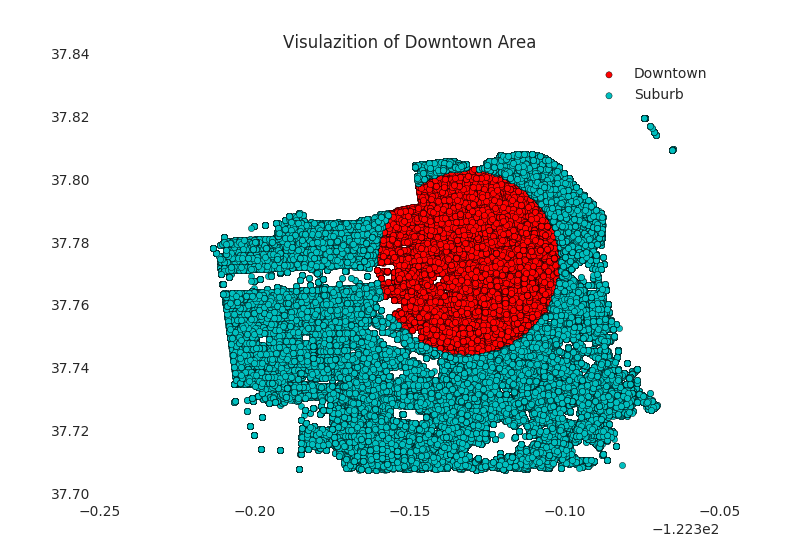

In [20]:
# draw area
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(df['X'],df['Y'],c='r',label='Downtown')
ax.scatter(df2['X'],df2['Y'],c='c',label='Suburb')
ax.legend()
ax.set_title('Visulazition of Downtown Area')
display(fig.figure)

#### Part4  (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give our insights for the output results. What is the business impact for result?

In [22]:
from pyspark.sql import functions as F
# extract month,day and year from Data column and convert them to numeric type inorder to ascending order
temp2=df_opt1.withColumn('Month',df_opt1.Date.substr(1,2).cast(IntegerType())).withColumn('Day',
 df_opt1.Date.substr(4,2).cast(IntegerType())).withColumn('Year',df_opt1.Date.substr(7,4).cast(IntegerType()))


In [23]:
# count the num of each month for these years
q4_result=temp2.filter('Year!=2018').groupBy('Month').count().orderBy('Month',ascending=True)
display(q4_result)

Month,count
1,65190
2,59924
3,65845
4,63037
5,64919
6,62275
7,64501
8,66118
9,64345
10,67119


***Insights*** : From above figure, it shows that for average, the num of crimes happened on month 1,3,8,10 are higher, the lowest ones are 2,12,11 and 6, so it's better to visit SF on these month.

In [25]:
# count the number in each month of each year
q4_result2=temp2.filter('Year!=2018').groupBy('Year','Month').count().orderBy('Year','Month',ascending=True)
display(q4_result2)

Year,Month,count
2013,1,12757
2013,2,11732
2013,3,12938
2013,4,12456
2013,5,12877
2013,6,12371
2013,7,13033
2013,8,13610
2013,9,13725
2013,10,13848


***Insights***: By analysis the tendency of num of crimes happened at each month, on average, it's increase with recent years for almost every month, but for 8,9 and 10, the tendency is slightly decreasing.

In [27]:
# Here we give a pivot table as conclusion.
q4_result3=temp2.filter('Year!=2018').groupBy('Year').pivot('Month').count().orderBy('Year',ascending=True)
display(q4_result3)

Year,1,2,3,4,5,6,7,8,9,10,11,12
2013,12757,11732,12938,12456,12877,12371,13033,13610,13725,13848,12217,11242
2014,12777,11565,12887,12353,12314,11901,12741,13435,12541,13381,12120,12113
2015,13606,12329,13929,12959,13729,13304,13365,13730,12896,13147,12091,11441
2016,12966,12106,12380,12328,12732,12094,12191,12471,12499,13388,12720,13007
2017,13084,12192,13711,12941,13267,12605,13171,12872,12684,13355,12347,12544


#### Part5 (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give our travel suggestion to visit SF.

***Idea***: Here we choose Christmas Day to analysis, and thus give suggestions to visit SF at the holiday

In [30]:
q5_result=temp2.filter((temp2['Month']=='12') & (temp2['Day']=='25')).groupBy(temp2.Time.substr(1,2).alias('hour')).count().orderBy('hour',ascending=True)
display(q5_result)

hour,count
00,76
01,53
02,30
03,25
04,21
05,13
06,23
07,30
08,36
09,35


***Insights***: Given the tendency of crimes happened with hours at the Christmas Day, it's better to hang out before noon, and you need to be careful during the night, especially after 20:00

In [32]:
from pyspark.sql.types import StringType,IntegerType
def getInterval(time):
    start = int(time.split(":")[0])-int(time.split(":")[0])%6
    return start
getIntervalUdf = udf(lambda x:getInterval(x),IntegerType())
temp2= temp2.withColumn("Interval",getIntervalUdf("Time"))
q5_result2=temp2.filter((temp2['Month']=='12') & (temp2['Day']=='25')).groupby('Interval').count().orderBy('Interval',ascending=True)
display(q5_result2)

Interval,count
0,218
6,218
12,356
18,398


***Insight***: Analysis of time intervals during the day gives us similar pictures, if we split the whole day into four intervals: <br>
(1)0-6 : Before Dawn
<br>
(2)6-12: Before Meridiem
<br>
(3)12-18: Afternoon
<br>
(4)18-24: Evening
<br>
The totally increasing tendency is obivous, so again, better to go out before meridiem, and pay attention to safetly during evening

In [34]:
temp2=temp2.withColumn('Hour',temp2.Time.substr(1,2))

#### Part6 (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give our advice to distribute the police based on our analysis results.

In [36]:
# use take would convert the result to a list, while limit can maintain the dataframe types
q6_step1=temp2.groupBy('PdDistrict').count().orderBy('count',ascending=False).limit(3)
display(q6_step1)

PdDistrict,count
SOUTHERN,153747
MISSION,106994
NORTHERN,104025


In [37]:
# For step2, we need first filter the rows with these three district
# method 1, using inner join to filter out the top 3 district
temp3=temp2.join(q6_step1,temp2.PdDistrict==q6_step1.PdDistrict).select(temp2.PdDistrict,'Category','Interval').orderBy(temp2.PdDistrict)


In [38]:
temp2.join(q6_step1,temp2.PdDistrict==q6_step1.PdDistrict).show(5)

+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+-----+---+----+--------+----+----------+------+
IncidntNum| Category| Descript|DayOfWeek| Date| Time|PdDistrict| Resolution| Address| X| Y| Location| PdId|Month|Day|Year|Interval|Hour|PdDistrict| count|
+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+-----+---+----+--------+----+----------+------+
 180362289| VEHICLE THEFT| STOLEN MOTORCYCLE| Tuesday|05/15/2018|10:30| SOUTHERN| NONE|700 Block of TEHA...|-122.41191202732877| 37.77520656149669|(37.7752065614966...|18036228907023| 5| 15|2018| 6| 10| SOUTHERN|153747|
 180360948| NON-CRIMINAL|AIDED CASE, MENTA...| Tuesday|05/15/2018|04:14| SOUTHERN| NONE|MARKET ST / SOUTH...|-122.41925789481357| 37.77514629165388|(37.7751462916538...|18036094864020| 5| 15|2018| 0| 04| SOUTHERN|153747|
 180360879|OTHER OFFENSES| PAROLE VIOLATION| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087926150| 5| 15|2018| 0| 02| MISSION|106994|
 180360879|OTHER OFFENSES|TRAFFIC VIOLATION...| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965010| 5| 15|2018| 0| 02| MISSION|106994|
 180360879|OTHER OFFENSES| TRAFFIC VIOLATION| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965015| 5| 15|2018| 0| 02| MISSION|106994|
+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+-----+---+----+--------+----+----------+------+
only showing top 5 rows

In [39]:
# temp2.filter("temp2.PdDistrict=q6_step1.PdDistrict").show()

In [40]:
#temp2.filter(temp2.PdDistrict.isin(q6_step1.PdDistrict)==True).show()

In [41]:
# Step2: find out the crime event w.r.t category and time (hour) from the result of step 1
# .filter(temp3['PdDistrict']=='PARK')
# 'PdDistrict',
crime_categ=temp3.groupBy('PdDistrict','Category').count().orderBy('count',ascending=False).limit(30)
display(crime_categ)

PdDistrict,Category,count
SOUTHERN,LARCENY/THEFT,51719
NORTHERN,LARCENY/THEFT,37962
MISSION,LARCENY/THEFT,20596
SOUTHERN,NON-CRIMINAL,19609
SOUTHERN,OTHER OFFENSES,17084
MISSION,OTHER OFFENSES,15558
MISSION,NON-CRIMINAL,13032
SOUTHERN,ASSAULT,11811
MISSION,ASSAULT,11161
NORTHERN,NON-CRIMINAL,11026


***Insights***:Based on above results, we figure out the rank of category of crimes happened at each region.
<br>
(1) For Southern, top3 are larceny/theft, non-criminal and other offense.
<br>
(2) For Northern, they're the same with Southern, while non-criminal and other offenses are close
<br>
(3) For Mission, they're larceny/theft, other offense and non-criminal, and assault which is adjacent to non-criminal

In [43]:
crime_hour=temp3.groupBy('PdDistrict','Interval').count().orderBy('Interval',ascending=True)
display(crime_hour)

PdDistrict,Interval,count
NORTHERN,0,16216
MISSION,0,19264
SOUTHERN,0,19654
MISSION,6,19516
NORTHERN,6,19591
SOUTHERN,6,31032
NORTHERN,12,32416
MISSION,12,33182
SOUTHERN,12,52279
MISSION,18,35032


***Insight***:Based on above analysis result, we get the distribution of crime happened at different time interval
<br>
(1) For Southern district, Peak appears at 12-18
<br>
(2) For Mission district, Peak appears at 18-24
<br>
(3) For Northern district, Peak appears at 18-24

In [45]:
# from pyspark.sql.functions import *
# crime_interval=temp3.groupBy('PdDistrict').agg((sort_array(collect_list('interval')))).count()
# print(crime_interval)

In [46]:
# here we check the top1 categorical crime happened at these 3 district at different time interval
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

crime_relation=temp3.groupBy('Interval','Category','PdDistrict').count().orderBy('count',ascending=False)

window = Window.partitionBy(crime_relation['PdDistrict'],crime_relation['Interval']).orderBy(crime_relation['count'].desc())

top1_interval=crime_relation.select('*', row_number().over(window).alias('rank')).filter('rank=1').orderBy('Interval',ascending=True)
display(top1_interval)

Interval,Category,PdDistrict,count,rank
0,LARCENY/THEFT,NORTHERN,4197,1
0,LARCENY/THEFT,SOUTHERN,4811,1
0,OTHER OFFENSES,MISSION,3112,1
6,LARCENY/THEFT,NORTHERN,6268,1
6,LARCENY/THEFT,SOUTHERN,8565,1
6,LARCENY/THEFT,MISSION,3209,1
12,LARCENY/THEFT,NORTHERN,11776,1
12,LARCENY/THEFT,MISSION,6076,1
12,LARCENY/THEFT,SOUTHERN,17356,1
18,LARCENY/THEFT,NORTHERN,15721,1


***Insight***: To summary
<br> At interval 0-6, the top 1 categorical crimes for Northern and Southern are Larceny/theft, and for Mission, it's other offenses
<br> At interval 6-24, the top 1 categorical crimes for all three area are Larceny/theft
<br> Therefore, visitors should take care of their properties

In [48]:
display(top1_interval)

Interval,Category,PdDistrict,count,rank
0,LARCENY/THEFT,NORTHERN,4197,1
0,LARCENY/THEFT,SOUTHERN,4811,1
0,OTHER OFFENSES,MISSION,3112,1
6,LARCENY/THEFT,NORTHERN,6268,1
6,LARCENY/THEFT,SOUTHERN,8565,1
6,LARCENY/THEFT,MISSION,3209,1
12,LARCENY/THEFT,NORTHERN,11776,1
12,LARCENY/THEFT,MISSION,6076,1
12,LARCENY/THEFT,SOUTHERN,17356,1
18,LARCENY/THEFT,NORTHERN,15721,1


***Insight***:Based on the relationship between time interval nad crime number for these three region, the policy distributed should take the highest crime number in each interval for each regison.
<br>
For example, at all the time, obviously Southern had much higher probility of crime happening,  the police should focus more on this region.
<br>
What'more, at most time, the top1 crime in both three region are larceny/theft, so it's better to notice residuence and visiters to pay attention to it at these specific time interval

#### Part7 (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give our hints to adjust the policy.

In [51]:
df_opt1.select('Resolution').distinct().show()

+--------------------+
 Resolution|
+--------------------+
 JUVENILE BOOKED|
EXCEPTIONAL CLEAR...|
 ARREST, BOOKED|
CLEARED-CONTACT J...|
PROSECUTED FOR LE...|
 LOCATED|
 UNFOUNDED|
DISTRICT ATTORNEY...|
 JUVENILE ADMONISHED|
 PSYCHOPATHIC CASE|
COMPLAINANT REFUS...|
 JUVENILE DIVERTED|
 JUVENILE CITED|
 ARREST, CITED|
PROSECUTED BY OUT...|
 NONE|
 NOT PROSECUTED|
+--------------------+

In [52]:
from pyspark.sql.functions import avg, col, when
q7_result=df_opt1.groupBy('Category').agg(avg(when(col('Resolution') !='NONE',1).otherwise(0)).alias('Percentage')).orderBy('Percentage')
display(q7_result)

Category,Percentage
LARCENY/THEFT,0.05286438419517467
BAD CHECKS,0.07272727272727272
VEHICLE THEFT,0.0847913862718708
RECOVERED VEHICLE,0.08913738019169329
SUSPICIOUS OCC,0.12129685107516144
VANDALISM,0.12640678519001794
EXTORTION,0.1483050847457627
FRAUD,0.17229797810169947
BURGLARY,0.1862015018773467
SUICIDE,0.20558375634517767


***Insight***:Here we can see the percentage of resolution for larceny/theft, bad checks, vehicle theft and recovered vehicle are below 10% .
<br>
In contrast, that for driving under influence, warrants, stolen property and drug/narcotic, the percentage are above 90%.

In [54]:
from pyspark.sql.window import Window
q7_result2=df_opt1.groupBy('Category','Resolution').count().select('Category','Resolution',F.col('count').alias('Counts'))
# q7_result2.select(q7_result2.count.cast(IntegerType())).agg(sum('count')).show()
q7_result2=q7_result2.withColumn('Percentage',col('Counts')/F.sum(q7_result2.Counts).over(Window.partitionBy(df_opt1['Category']))).orderBy('Percentage',ascending=False)
display(q7_result2)


Category,Resolution,Counts,Percentage
LARCENY/THEFT,NONE,206844,0.9471356158048253
BAD CHECKS,NONE,153,0.9272727272727272
WARRANTS,"ARREST, BOOKED",30757,0.9177084887363867
VEHICLE THEFT,NONE,31960,0.9152086137281292
RECOVERED VEHICLE,NONE,2851,0.9108626198083067
DRIVING UNDER THE INFLUENCE,"ARREST, BOOKED",1829,0.9018737672583826
SUSPICIOUS OCC,NONE,26398,0.8787031489248386
VANDALISM,NONE,37492,0.8735932148099821
STOLEN PROPERTY,"ARREST, BOOKED",4566,0.8725396522071469
DRUG/NARCOTIC,"ARREST, BOOKED",21700,0.8519827247742442


***Insight***:
Digging into the specific types of resolution, it shows that for almost all category, the main resolution is None, arrest, cited or arrest, booked.
<br>
From above collection, we can figure out the distribution of resolution for each categories, for example, for warrants, driving under the influence and stolen property, the rate of arrested is as high as 91.7%,90.2% and 87.25%

#### Part8 (Apply Spark ML clustering for spatial data analysis)
visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)  
You can refer Spark ML Kmeans a example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [57]:
# view the dataset
display(temp2)

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Month,Day,Year,Interval,Hour
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,5,15,2018,6,10
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,5,15,2018,0,04
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,5,15,2018,0,02
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010,5,15,2018,0,02
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015,5,15,2018,0,02
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016,5,15,2018,0,01
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074,5,15,2018,0,01
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710,5,15,2018,0,01
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030,5,15,2018,0,00
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050,5,15,2018,0,00


In [58]:
# data-preprocessing
# drop some repeat, nonsense columns
train_data=temp2.drop('IncidntNum','Descript','Date','Time','Address','PdId','Hour')
# encoding category variables
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml import Pipeline
category_columns=['Category','DayOfWeek','PdDistrict','Resolution']
stages = [] # stages in our Pipeline
for categoricalCol in category_columns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]
# Transform all features into a vector using VectorAssembler
numericCols = ['X','Y',"Month", "Day", "Year", "Interval"]   
# convert numeric columns from string type to integer 
for columns in numericCols[2:-1]:
  train_data=train_data.withColumn(columns,col(columns).cast(IntegerType()))
for columns in numericCols[:2]:
  train_data=train_data.withColumn(columns,col(columns).cast(FloatType()))
# define udf to convert location  
def StrToArray(x):
  res=[]
  start=1
  for i in range(len(x)):
    if x[i]==',':
      end=i
  res.append(float(x[start:end]))
  res.append(float(x[end+1:-2]))
  return res
StrToArray_udf=udf(lambda x:StrToArray(x),ArrayType(FloatType()))
train_data=train_data.withColumn('Location',StrToArray_udf('Location'))
display(train_data)

Category,DayOfWeek,PdDistrict,Resolution,X,Y,Location,Month,Day,Year,Interval
VEHICLE THEFT,Tuesday,SOUTHERN,NONE,-122.41191,37.775208,"List(37.775208, -122.41191)",5,15,2018,6
NON-CRIMINAL,Tuesday,SOUTHERN,NONE,-122.41926,37.775146,"List(37.775146, -122.41926)",5,15,2018,0
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0
OTHER OFFENSES,Tuesday,MISSION,NONE,-122.41562,37.756413,"List(37.756413, -122.41562)",5,15,2018,0
ROBBERY,Tuesday,SOUTHERN,"ARREST, BOOKED",-122.41004,37.78195,"List(37.78195, -122.41004)",5,15,2018,0
DRUG/NARCOTIC,Tuesday,SOUTHERN,"ARREST, BOOKED",-122.41004,37.78195,"List(37.78195, -122.41004)",5,15,2018,0
LIQUOR LAWS,Tuesday,PARK,"ARREST, BOOKED",-122.44776,37.769848,"List(37.769848, -122.44776)",5,15,2018,0
WARRANTS,Tuesday,PARK,"ARREST, BOOKED",-122.44776,37.769848,"List(37.769848, -122.44776)",5,15,2018,0


In [59]:
# create dataset including feature column for run k-means
assemblerInputs = [c + "classVec" for c in category_columns] + numericCols
assembler = VectorAssembler(inputCols=['X','Y'], outputCol="features")
stages += [assembler]
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(train_data)
preppedDataDF = pipelineModel.transform(train_data)

In [60]:
display(preppedDataDF)

Category,DayOfWeek,PdDistrict,Resolution,X,Y,Location,Month,Day,Year,Interval,CategoryIndex,CategoryclassVec,DayOfWeekIndex,DayOfWeekclassVec,PdDistrictIndex,PdDistrictclassVec,ResolutionIndex,ResolutionclassVec,features
VEHICLE THEFT,Tuesday,SOUTHERN,NONE,-122.41191,37.775208,"List(37.775208, -122.41191)",5,15,2018,6,5.0,"List(0, 38, List(5), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",0.0,"List(0, 9, List(0), List(1.0))",0.0,"List(0, 16, List(0), List(1.0))","List(1, 2, List(), List(-122.41191101074219, 37.77520751953125))"
NON-CRIMINAL,Tuesday,SOUTHERN,NONE,-122.41926,37.775146,"List(37.775146, -122.41926)",5,15,2018,0,2.0,"List(0, 38, List(2), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",0.0,"List(0, 9, List(0), List(1.0))",0.0,"List(0, 16, List(0), List(1.0))","List(1, 2, List(), List(-122.41925811767578, 37.775146484375))"
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0,1.0,"List(0, 38, List(1), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",1.0,"List(0, 9, List(1), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))"
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0,1.0,"List(0, 38, List(1), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",1.0,"List(0, 9, List(1), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))"
OTHER OFFENSES,Tuesday,MISSION,"ARREST, BOOKED",-122.417816,37.7571,"List(37.7571, -122.417816)",5,15,2018,0,1.0,"List(0, 38, List(1), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",1.0,"List(0, 9, List(1), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))"
OTHER OFFENSES,Tuesday,MISSION,NONE,-122.41562,37.756413,"List(37.756413, -122.41562)",5,15,2018,0,1.0,"List(0, 38, List(1), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",1.0,"List(0, 9, List(1), List(1.0))",0.0,"List(0, 16, List(0), List(1.0))","List(1, 2, List(), List(-122.41561889648438, 37.756412506103516))"
ROBBERY,Tuesday,SOUTHERN,"ARREST, BOOKED",-122.41004,37.78195,"List(37.78195, -122.41004)",5,15,2018,0,11.0,"List(0, 38, List(11), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",0.0,"List(0, 9, List(0), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.41004180908203, 37.781951904296875))"
DRUG/NARCOTIC,Tuesday,SOUTHERN,"ARREST, BOOKED",-122.41004,37.78195,"List(37.78195, -122.41004)",5,15,2018,0,9.0,"List(0, 38, List(9), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",0.0,"List(0, 9, List(0), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.41004180908203, 37.781951904296875))"
LIQUOR LAWS,Tuesday,PARK,"ARREST, BOOKED",-122.44776,37.769848,"List(37.769848, -122.44776)",5,15,2018,0,28.0,"List(0, 38, List(28), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",8.0,"List(0, 9, List(8), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.44776153564453, 37.76984786987305))"
WARRANTS,Tuesday,PARK,"ARREST, BOOKED",-122.44776,37.769848,"List(37.769848, -122.44776)",5,15,2018,0,6.0,"List(0, 38, List(6), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))",8.0,"List(0, 9, List(8), List(1.0))",1.0,"List(0, 16, List(1), List(1.0))","List(1, 2, List(), List(-122.44776153564453, 37.76984786987305))"


In [61]:
cat_dis=preppedDataDF.select('Category').distinct().toPandas()

In [62]:
# convert dataset to pandas inorder to visulize it
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
vis=preppedDataDF.select('X','Y','Category','Interval').orderBy('Category')

# convert category to stringindexer then assign color to each category
category_Indexer = StringIndexer(inputCol='Category', outputCol="CategoryIndex")
model=category_Indexer.fit(vis)
td = model.transform(vis)
pvis=td.toPandas()
pvis2=vis.toPandas()

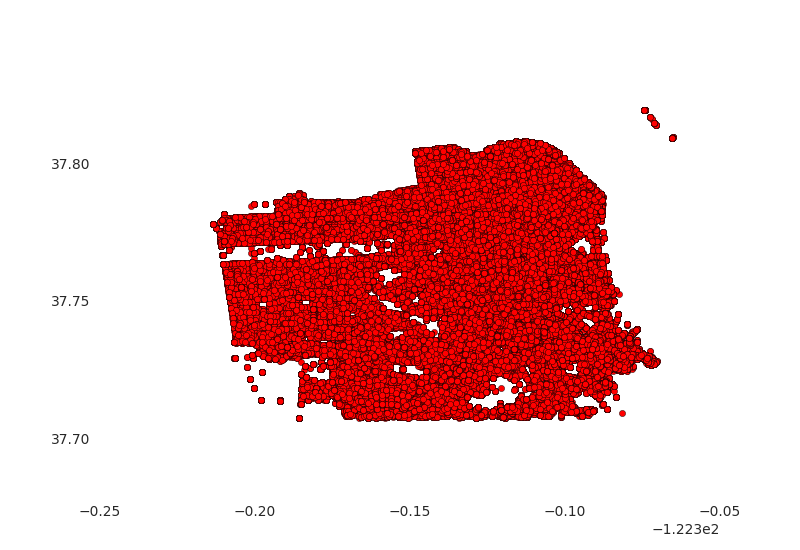

In [63]:
# visulize the spatial location of crimes in SF 
fig,ax=plt.subplots()
ax.scatter(pvis['X'],pvis['Y'],c='r')
display(fig.figure)

***Idea***
<br>From above figure, it seems like there has no distinct clusters, thus run k-means may not get good clusters that makes any sense, we would try it to test our idea

In [65]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(preppedDataDF)

# Make predictions
predictions = model.transform(preppedDataDF)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6709452650182511
Cluster Centers: 
[-122.46145571 37.74824413]
[-122.41256856 37.77426806]

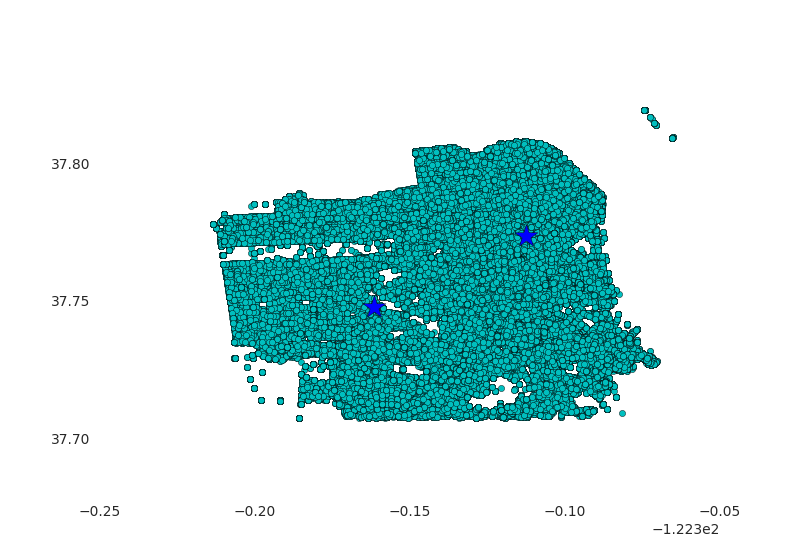

In [66]:
fig,ax=plt.subplots()
ax.scatter(pvis['X'],pvis['Y'],c='c')
ax.scatter([sublist[0] for sublist in centers],[sublist[1] for sublist in centers],c='b',marker='*',s=300) # here centers is a list of list, we cannot slice it directly, so we use list comprehension to get the list of x and list of y
display(fig.figure)

***Insight***
<br>
From above figure, the two centers seems not make much sense as there does not exist distinctive boundary. Next, we will try to visulize the spatial location based on category to see if it can give us some insight.

In [68]:
cat_dis

Out[ 180 ]: 
 Category
0 FRAUD
1 SUICIDE
2 LIQUOR LAWS
3 SECONDARY CODES
4 FAMILY OFFENSES
5 MISSING PERSON
6 OTHER OFFENSES
7 DRIVING UNDER THE INFLUENCE
8 WARRANTS
9 ARSON
10 FORGERY/COUNTERFEITING
11 GAMBLING
12 BRIBERY
13 ASSAULT
14 DRUNKENNESS
15 EXTORTION
16 TREA
17 WEAPON LAWS
18 LOITERING
19 SUSPICIOUS OCC
20 ROBBERY
21 SEX OFFENSES, FORCIBLE
22 PROSTITUTION
23 EMBEZZLEMENT
24 BAD CHECKS
25 DISORDERLY CONDUCT
26 RUNAWAY
27 RECOVERED VEHICLE
28 VANDALISM
29 DRUG/NARCOTIC
30 PORNOGRAPHY/OBSCENE MAT
31 TRESPASS
32 VEHICLE THEFT
33 NON-CRIMINAL
34 STOLEN PROPERTY
35 LARCENY/THEFT
36 KIDNAPPING
37 BURGLARY
38 SEX OFFENSES, NON FORCIBLE

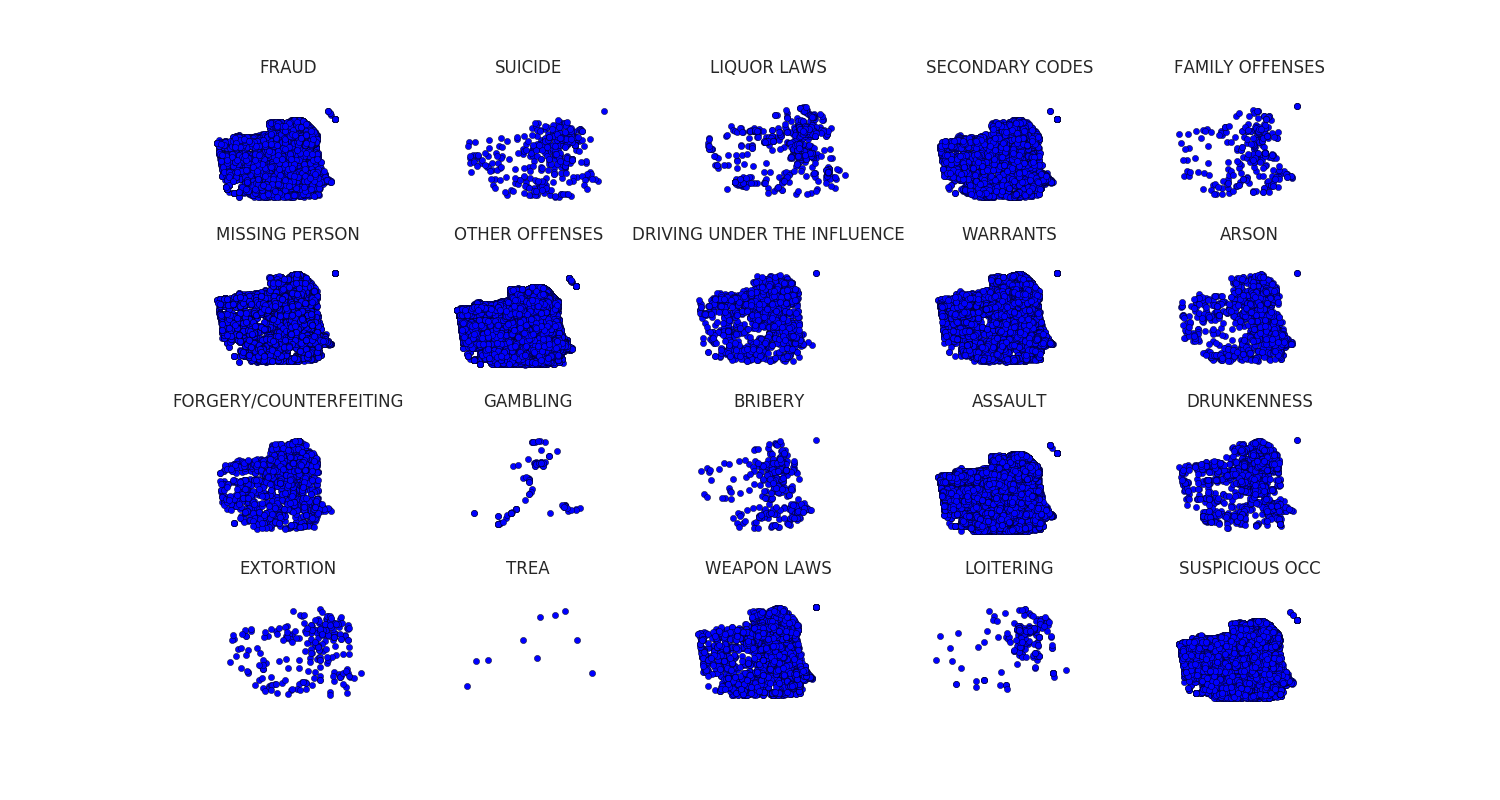

In [69]:
figs,axs=plt.subplots(4,5,figsize=(15,8))
i,j=0,0

for item in cat_dis['Category']:
  if i==4:
    break
  df=pvis.loc[pvis['Category']==item]
  axs[i][j].scatter(df['X'],df['Y'],label=item)
  axs[i][j].set_title(item)
  axs[i][j].axis('off')
  j+=1
  if j==5:
    i+=1
    j=0
display(figs.figure)  

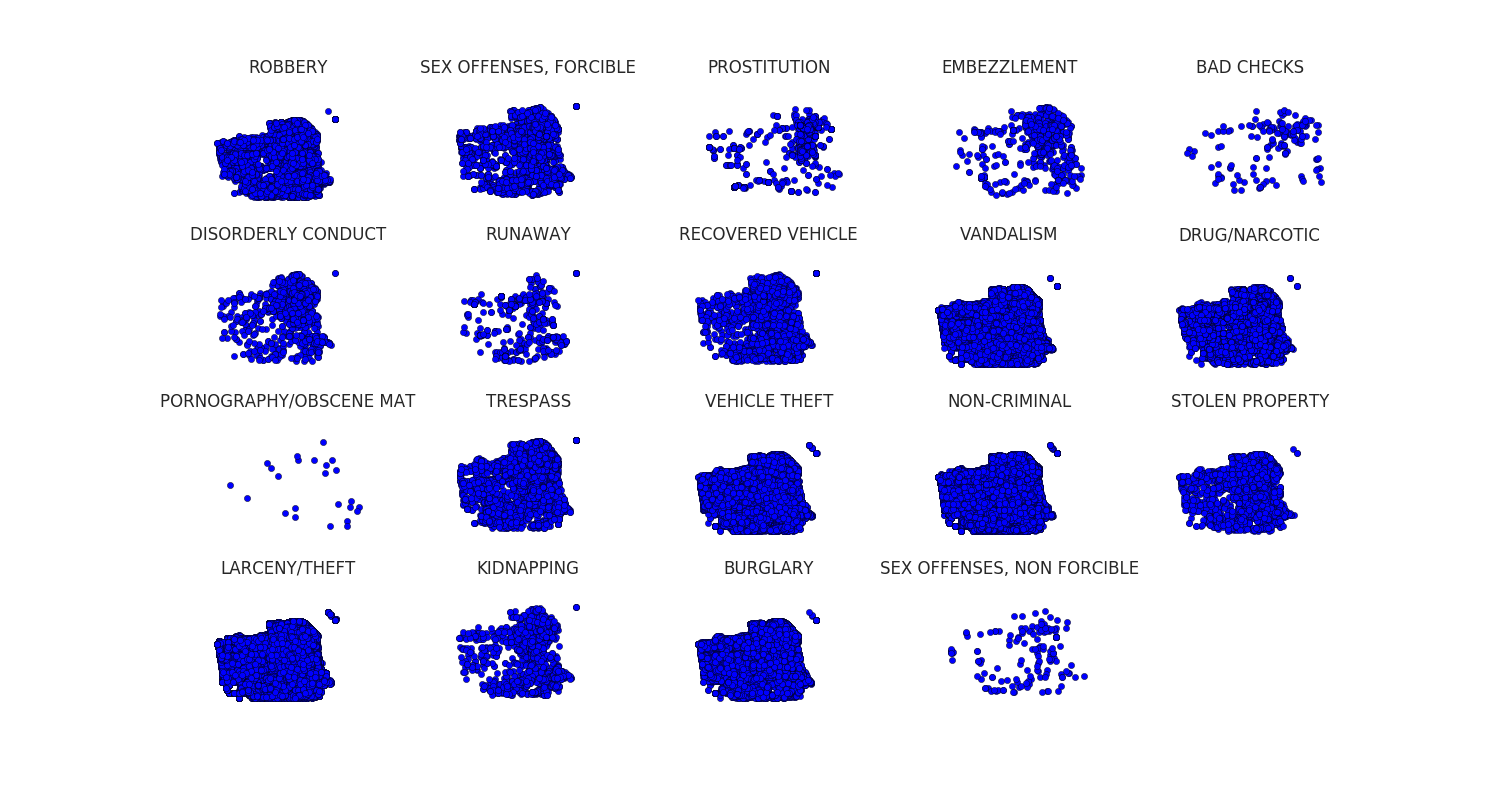

In [70]:
figs,axs=plt.subplots(4,5,figsize=(15,8))
i,j=0,0

for item in cat_dis['Category'][20:]:
  df=pvis.loc[pvis['Category']==item]
  axs[i][j].scatter(df['X'],df['Y'],label=item)
  axs[i][j].set_title(item)
  axs[i][j].axis('off')
  j+=1
  if j==5:
    i+=1
    j=0
axs[3][4].axis('off')
display(figs.figure)  

In [71]:
selected=['SUICIDE','LIQUOR LAWS','FAMILY OFFENSES','BRIBERY','EXTORTION','LOITERING',
          'PROSTITUTION','EMBEZZLEMENT','BAD CHECKS','DISORDERLY CONDUCT','RUNAWAY','KIDNAPPING']


In [72]:
# fig,ax=plt.subplots()
# color=[ 'g', 'r', 'c', 'm', 'y', 'k', 'w','b']
# i=0
# for item in cat_dis['Category']:
#   df=pvis.loc[pvis['Category']==item]
#   ax.scatter(df['X'],df['Y'],c=color[i],label=item)
#   i+=1
#   if i==8:
#     break
#   ax.legend(loc=2)
# display(fig.figure) 



  

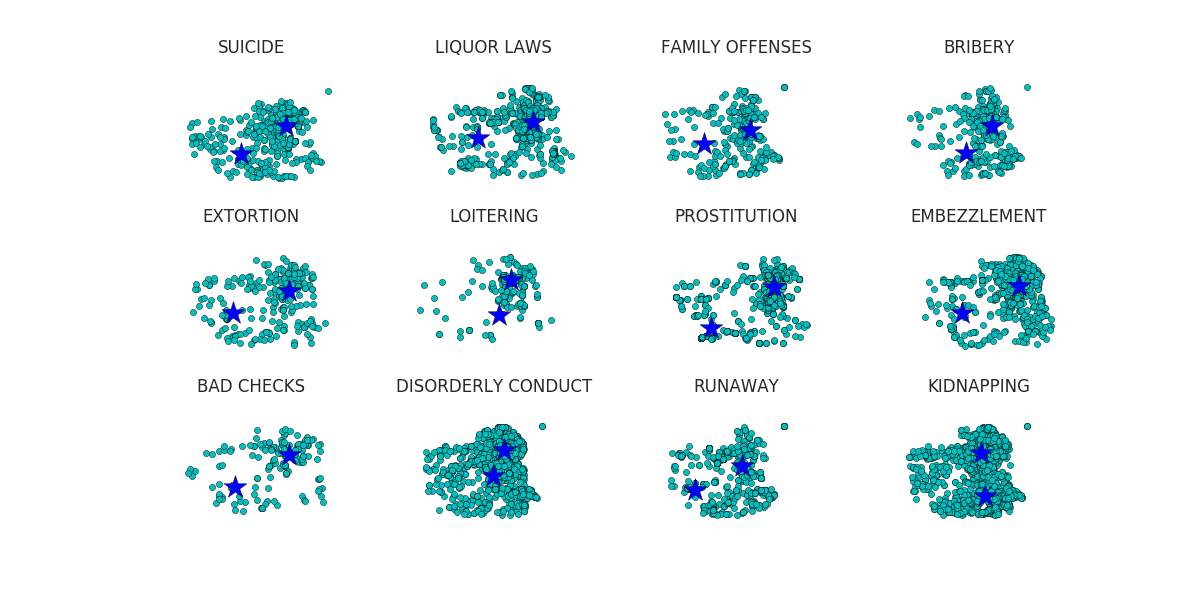

In [73]:
figs,axs=plt.subplots(3,4,figsize=(12,6))
i,j=0,0
for categorys in selected:
  df=preppedDataDF.filter(preppedDataDF["Category"]==categorys)
  pdf=df.toPandas()
  # Trains a k-means model.
  kmeans = KMeans().setK(2).setSeed(1) # a estimator
  model = kmeans.fit(df) # a transformer
  # Make predictions
  predictions = model.transform(df)  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  # get two centers
  centers = model.clusterCenters()
  
  # draw figures
  axs[i][j].scatter(pdf['X'],pdf['Y'],label=categorys,c='c')
  # draw centers
  axs[i][j].scatter([sublist[0] for sublist in centers],[sublist[1] for sublist in centers],c='b',marker='*',s=300)
  axs[i][j].set_title(categorys)
  axs[i][j].axis('off')
  j+=1
  if j==4:
    i+=1
    j=0
display(figs.figure)  
  
  

In [74]:
# from pyspark.ml.clustering import KMeans
# from pyspark.ml.evaluation import ClusteringEvaluator

# # Trains a k-means model.
# kmeans = KMeans().setK(2).setSeed(1)
# model = kmeans.fit(preppedDataDF)

# # Make predictions
# predictions = model.transform(preppedDataDF)

# # Evaluate clustering by computing Silhouette score
# evaluator = ClusteringEvaluator()

# silhouette = evaluator.evaluate(predictions)
# print("Silhouette with squared euclidean distance = " + str(silhouette))

# # Shows the result.
# centers = model.clusterCenters()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)

Silhouette with squared euclidean distance = 0.6709452650182511
Cluster Centers: 
[-122.46145571 37.74824413]
[-122.41256856 37.77426806]

##Conclusion##
As a metropolis in U.S, the crime happenes in SF has huge impact on its reputation, in this project, I analysis the crime record in SF from 2013-2018, which has 811784 rows in total, to give certain insights to help understanding of crimes happenes, thus improve the management and precaution of crimes for SF polices.
<br>
* The whole project split into two parts, first is data preprocessing and descriptive analysis of crime records by building data ETL pipeline and conducting OLAP via Pyspark on databricks platform with respect to the distribution of crime categories, districts, day of weeks, month and time intervals, and did data visulization to give strightforward view of results.
<br>
* Based on the insights provided by the previous step, run k-means on spatial location based on certain categories with distinct patterns to cluster them by constructing machine learning pipeline and also visulizing them.
<br>
* According to the analysis results, it's much clear about the relatinship between crimes happened and categories, district and times, and thus offer suggestion to local police department about how to deploy the police strength to better control the crimes, besides, visitors to SF can get a picture about crimes happened at different district and time intervals so that they can protect themselves better

### Optional part: Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.      
process:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction 

Refer:   
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244